In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from arbitragelab.cointegration_approach.minimum_profit import MinimumProfit
from arbitragelab.util.split_dataset import train_test_split
from arbitragelab.cointegration_approach.trading_simulation import TradingSim
from arbitragelab.cointegration_approach.coint_sim import CointegrationSimulation

## Cointegration Simulation

Simulating the following cointegrated processes:

(Will fill in the equations afterwards)

In [3]:
coint_simulator = CointegrationSimulation(20, 250)

In [4]:
price_params = {
    "ar_coeff": 0.95,
    "white_noise_var": 0.5,
    "constant_trend": 1.5
}

coint_params = {
    "ar_coeff": 0.9,
    "white_noise_var": 1.,
    "constant_trend": 0.05,
    "beta": -0.6
}

coint_simulator.load_params(price_params, target='price')
coint_simulator.load_params(coint_params, target='coint')

In [5]:
s1_series, s2_series, coint_errors = coint_simulator.simulate_coint(initial_price=100., use_statsmodel=True)

The simulated cointegration series visualized:

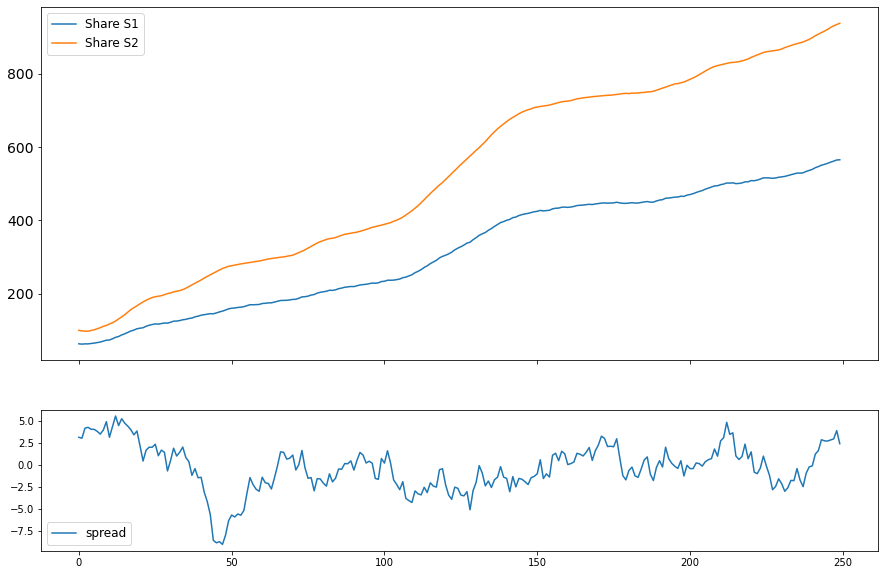

In [6]:
coint_sim_fig = coint_simulator.plot_coint_series(s1_series[:, 0], s2_series[:,0], coint_errors[:,0])

## Minimum Profit Optimization Trading Simulation

Selected Ametek Inc. (Ticker: AME) and Dover Corp. (Ticker: DOV) as the cointegrated pairs for trading. Used data from 2016 Jan 4th to 2018 Dec 31st for training. Simulated the trades using data from 2019 Jan 2nd to date. The simulation trading account has \\$1M at the start of the trading simulation, and the minimum profit was set at 0.5\% of the account, i.e. \\$5,000.

In [7]:
data_path = 'tests/test_data/AME-DOV.csv'
data = pd.read_csv(data_path, parse_dates=['Date'])
data.set_index('Date', inplace=True)

In [8]:
trade_account = TradingSim(starting_equity=1000000.)
optimizer = MinimumProfit(data)
train_df, trade_df = train_test_split(optimizer.price_df, date_cutoff=pd.Timestamp(2019, 1, 1))

We use Engle-Granger test to calculate cointegration coefficient.

In [9]:
beta_eg, epsilon_t_eg, ar_coeff_eg, ar_resid_eg = optimizer.fit(train_df, use_johansen=False)

C:\Anaconda3\envs\arbitragelab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


These two stocks passed the cointegration test at 95% significance level over the training period. Therefore, we can proceed to the optimization step. The optimization progress was shown as it may take some time to complete.

In [10]:
trade_days = len(trade_df)
optimal_ub, _, _, optimal_mtp, optimal_num_of_trades = optimizer.optimize(ar_coeff_eg, epsilon_t_eg, 
                                                                          ar_resid_eg, len(train_df))

trade_signals, num_of_shares, cond_values = optimizer.trade_signal(trade_df, optimal_ub, 5000, beta_eg, epsilon_t_eg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1858/1858 [17:44<00:00,  1.74it/s]


The optimal upperbound is 2.05, which means if we trade one unit of the spread, the minimum profit should be \\$2.05. In order to achieve the minimum profit of \\$5,000, we need to trade multiple (will insert number afterwards) units.

In [11]:
optimal_ub

2.05

In [12]:
num_of_shares

array([2440., 2316.])

We have acquired the trading signal as well as the amount to trade. Now we can start trading!

In [13]:
trade_account.trade(trade_signals, num_of_shares)

Below are the summary of each trade (open date, open entry price, close date, closing price), the plot of trading signals based on cointegration error, and the equity curve (marked to market everyday) of the trading strategy.

In [14]:
trade_account.summary()

,Trade Date,Trade Type,Leg 1,Leg 1 Shares,Leg 1 Price,Leg 2,Leg 2 Shares,Leg 2 Price
0,2019-01-01,U-trade Open,AME,-2440.0,67.70,DOV,2316.0,70.95
1,2019-01-14,U-trade Close,AME,2440.0,70.21,DOV,-2316.0,78.06
2,2019-01-29,L-trade Open,AME,2440.0,71.77,DOV,-2316.0,86.16
3,2019-05-22,L-trade Close,AME,-2440.0,85.61,DOV,2316.0,93.04
4,2019-06-04,L-trade Open,AME,2440.0,83.67,DOV,-2316.0,94.12
5,2019-07-11,L-trade Close,AME,-2440.0,89.59,DOV,2316.0,97.63
6,2019-07-17,U-trade Open,AME,-2440.0,89.28,DOV,2316.0,95.46
7,2019-07-19,U-trade Close,AME,2440.0,88.71,DOV,-2316.0,98.12
8,2019-08-01,U-trade Open,AME,-2440.0,88.32,DOV,2316.0,94.39
9,2019-09-03,U-trade Close,AME,2440.0,83.38,DOV,-2316.0,92.51


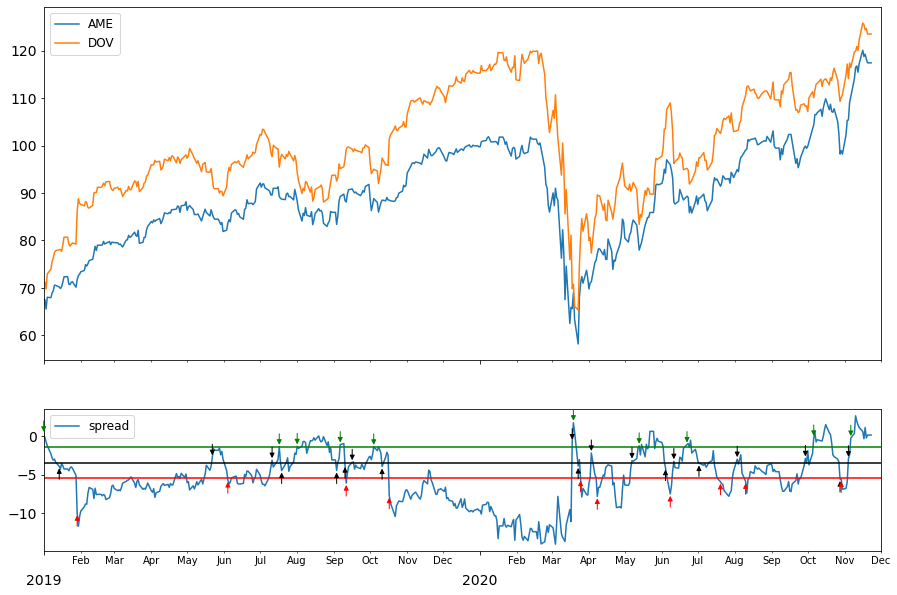

In [15]:
trade_account.plot_signals(trade_signals, cond_values, start_date=pd.Timestamp(2019, 1, 1), end_date=pd.Timestamp(2020,12,1))

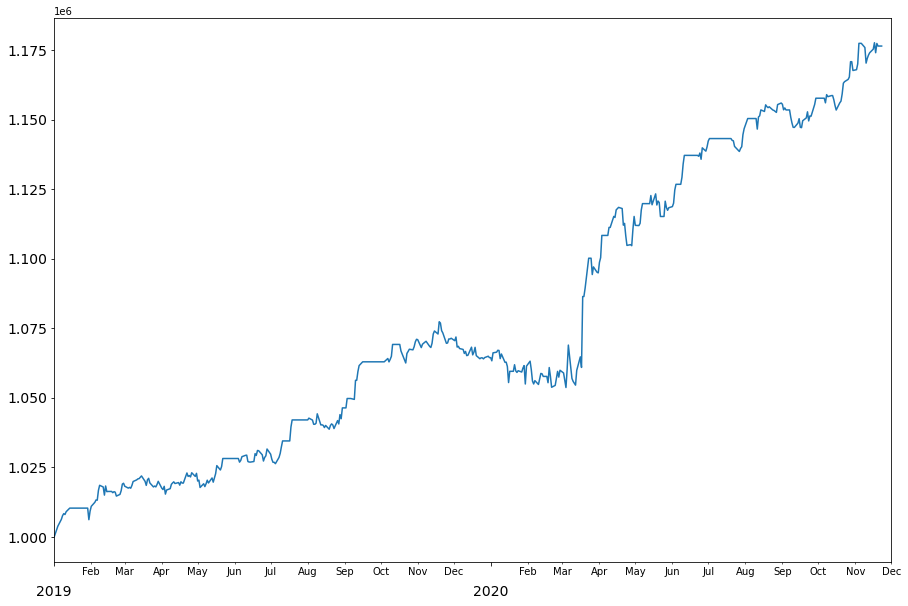

In [16]:
trade_account.plot_equity_curve(trade_signals, start_date=pd.Timestamp(2019, 1, 1), end_date=pd.Timestamp(2020,12,1))